**bold text**# CIP Deviations and its implications for Systemic Stress

Importing necessary libraries below

In [73]:
!pip install arch # Install the arch package
!pip install quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import quandl
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from statsmodels.nonparametric.kernel_regression import KernelReg
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR


In [74]:

from google.colab import drive
drive.mount('/content/drive')

file_path_ForwardRateUSDtoEUR = '/content/drive/MyDrive/Colab Notebooks/ForwardRateUSDtoEUR.xlsx'
df_ForwardRateUSDtoEUR = pd.read_excel(file_path_ForwardRateUSDtoEUR, engine='openpyxl', header=1)
print(df_ForwardRateUSDtoEUR.head())

file_path_SpotRateUSDtoEUR = '/content/drive/MyDrive/Colab Notebooks/SpotRateUSDtoEUR.xlsx'
df_SpotRateUSDtoEUR = pd.read_excel(file_path_SpotRateUSDtoEUR, engine='openpyxl', header=1)
print(df_SpotRateUSDtoEUR.head())

file_path_USDTreasuryRate = '/content/drive/MyDrive/Colab Notebooks/USDTreasuryRate.xlsx'
df_USDTreasuryRate = pd.read_excel(file_path_USDTreasuryRate, engine='openpyxl', header=1)
print(df_USDTreasuryRate.head())

file_path_EUROBIR = '/content/drive/MyDrive/Colab Notebooks/EUROBIR.xlsx'
df_EUROBIR = pd.read_excel(file_path_EUROBIR, engine='openpyxl', header=1)
print(df_EUROBIR.head())

file_path_GDP_growth = '/content/drive/MyDrive/Colab Notebooks/GDP_growth.xlsx'
df_GDP_growth = pd.read_excel(file_path_GDP_growth, engine='openpyxl', header=1)
print(df_GDP_growth.head())



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
        Date  ForwardRateUSDtoEUR  ForwardRateUSDtoEUR_low  \
0 2025-05-09             0.889205                 0.888099   
1 2025-05-08             0.890710                 0.882068   
2 2025-05-07             0.884956                 0.878812   
3 2025-05-06             0.879507                 0.878580   
4 2025-05-05             0.883783                 0.879894   

   ForwardRateUSDtoEUR_high  
0                  0.893096  
1                  0.891902  
2                  0.885583  
3                  0.886525  
4                  0.885583  
         Date SpotRateUSDtoEUR
0  1999-01-04         0.846597
1  1999-01-05          0.85034
2  1999-01-06         0.859402
3  1999-01-07         0.856751
4  1999-01-08         0.865501
         Date  USDTreasuryRate
0  1954-01-04             1.33
1  1954-01-05             1.28
2  1954-01-06             1.28
3  1954-

In [75]:
#Ensure 'Date' is parsed as a datetime
for df in [df_ForwardRateUSDtoEUR, df_SpotRateUSDtoEUR, df_USDTreasuryRate, df_EUROBIR]:
    df['Date'] = pd.to_datetime(df['Date'])
df_GDP_growth["Year"] = pd.to_datetime(df_GDP_growth["Year"], format="%Y")

In [76]:
# Merge all on 'Date'
merged = df_ForwardRateUSDtoEUR.merge(df_SpotRateUSDtoEUR, on='Date') \
               .merge(df_USDTreasuryRate, on='Date') \
               .merge(df_EUROBIR, on='Date')



merged = merged.sort_values("Date")
df_GDP_growth = df_GDP_growth.sort_values("Year")

# Create a 'Year' column in daily data
merged["Year"] = merged["Date"].dt.year

# Merge GDP to each daily observation based on the year
merged = merged.merge(df_GDP_growth, left_on="Year", right_on=df_GDP_growth["Year"].dt.year, how="left")

# Drop duplicate 'Year' columns if needed
merged = merged.drop(columns=["Year_y"])
merged = merged.rename(columns={"Year_x": "Year"})
# Preview result
print(merged.head())


   Year       Date  ForwardRateUSDtoEUR  ForwardRateUSDtoEUR_low  \
0  1999 1999-01-04             0.845666                 0.838012   
1  1999 1999-01-05             0.850268                 0.840901   
2  1999 1999-01-06             0.860956                 0.844666   
3  1999 1999-01-07             0.854263                 0.849618   
4  1999 1999-01-08             0.864304                 0.851934   

   ForwardRateUSDtoEUR_high SpotRateUSDtoEUR  USDTreasuryRate  EUROBIR  Year  \
0                  0.854847         0.846597             4.38    3.234  1999   
1                  0.852297          0.85034             4.37    3.223  1999   
2                  0.865576         0.859402             4.36    3.215  1999   
3                  0.861252         0.856751             4.33    3.205  1999   
4                  0.867002         0.865501             4.37    3.195  1999   

   GDP_growth  
0      0.0479  
1      0.0479  
2      0.0479  
3      0.0479  
4      0.0479  


In [77]:
#Ensuring all variables are numeric
merged["ForwardRateUSDtoEUR"] = pd.to_numeric(merged["ForwardRateUSDtoEUR"], errors="coerce")
merged["ForwardRateUSDtoEUR_low"] = pd.to_numeric(merged["ForwardRateUSDtoEUR_low"], errors="coerce")
merged["ForwardRateUSDtoEUR_high"] = pd.to_numeric(merged["ForwardRateUSDtoEUR_high"], errors="coerce")
merged["SpotRateUSDtoEUR"] = pd.to_numeric(merged["SpotRateUSDtoEUR"], errors="coerce")
merged["USDTreasuryRate"] = pd.to_numeric(merged["USDTreasuryRate"], errors="coerce")
merged["EUROBIR"] = pd.to_numeric(merged["EUROBIR"], errors="coerce")


In [78]:
# Check for invalid (non-positive) values before applying log
merged = merged[(merged["ForwardRateUSDtoEUR"] > 0) & (merged["SpotRateUSDtoEUR"] > 0)]

In [79]:
#Calculating CIP deviation according to Hernandez
merged["rho"] = np.log(merged["ForwardRateUSDtoEUR"]) - np.log(merged["SpotRateUSDtoEUR"])
merged["x"] = merged["USDTreasuryRate"] - merged["EUROBIR"] - merged["rho"]

#Compute trading costs from bid-ask spread
# -------------------------------
merged["ForwardSpread"] = merged["ForwardRateUSDtoEUR_high"] - merged["ForwardRateUSDtoEUR_low"]
merged["TradingCost"] = merged["ForwardSpread"] / merged["SpotRateUSDtoEUR"]  # Approx basis in returns

# Optional: replace zeros or NaNs with small value
merged["TradingCost"].replace(0, np.nan, inplace=True)
merged["TradingCost"].fillna(method="ffill", inplace=True)

<ipython-input-79-11262b560315>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged["TradingCost"].replace(0, np.nan, inplace=True)
<ipython-input-79-11262b560315>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

In [80]:
#saving data file with cip deviation, forward rate, spote rate, interest rates USD, EUR
merged.to_csv('merged.csv', index=False)
# Preview result
print(merged.head())

   Year       Date  ForwardRateUSDtoEUR  ForwardRateUSDtoEUR_low  \
0  1999 1999-01-04             0.845666                 0.838012   
1  1999 1999-01-05             0.850268                 0.840901   
2  1999 1999-01-06             0.860956                 0.844666   
3  1999 1999-01-07             0.854263                 0.849618   
4  1999 1999-01-08             0.864304                 0.851934   

   ForwardRateUSDtoEUR_high  SpotRateUSDtoEUR  USDTreasuryRate  EUROBIR  Year  \
0                  0.854847          0.846597             4.38    3.234  1999   
1                  0.852297          0.850340             4.37    3.223  1999   
2                  0.865576          0.859402             4.36    3.215  1999   
3                  0.861252          0.856751             4.33    3.205  1999   
4                  0.867002          0.865501             4.37    3.195  1999   

   GDP_growth       rho         x  ForwardSpread  TradingCost  
0      0.0479 -0.001100  1.147100       

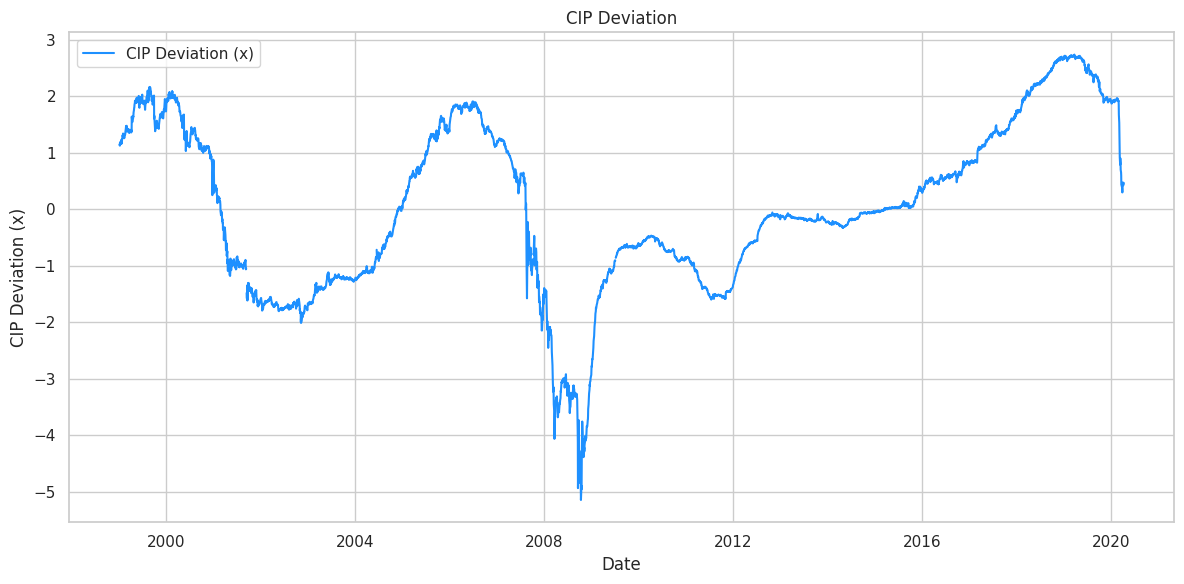

<Figure size 640x480 with 0 Axes>

In [81]:
#Creating graph for cip deviation over the years
merged = merged.sort_values("Date")
plt.figure(figsize=(12, 6))
plt.plot(merged["Date"], merged["x"], label="CIP Deviation (x)", color="dodgerblue")
plt.title("CIP Deviation")
plt.xlabel("Date")
plt.ylabel("CIP Deviation (x)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig("CIP Deviation.png")

In [82]:
#Generating inputs for CISS through reverse engineering from CISS measure provided by ECB

weights = {
    "Bond": 0.20,
    "Equity": 0.35,
    "Intermediaries": 0.30,
    "FX": 0.15
}
ROLLING_WINDOW = 52
labels = list(weights.keys())
weight_vec = np.array([weights[l] for l in labels])
# === 1. LOAD CONTRIBUTIONS FROM .XLSX FILES ===
def load_contrib_excel(file, name, weight):
    df = pd.read_excel(file, engine="openpyxl", header=1)
    df.columns = [col.strip() for col in df.columns]

    # Detect and rename 'Date' column
    if "Date" not in df.columns:
        if "TIME PERIOD" in df.columns:
            df.rename(columns={"TIME PERIOD": "Date"}, inplace=True)
        else:
            raise ValueError(f"No date column found in {file}")

    # Parse date
    df["Date"] = pd.to_datetime(df["Date"])

    # Rename contribution column (we expect it to be named like 'Bond', 'Equity', etc.)
    df.rename(columns={name: f"{name}_Contrib"}, inplace=True)

    # Convert to numeric (handles any stray text or symbols)
    df[f"{name}_Contrib"] = pd.to_numeric(df[f"{name}_Contrib"], errors="coerce")

    # Invert contribution to estimate subindex using sqrt(contribution / weight²)
    df[f"{name}_Input"] = np.sqrt((df[f"{name}_Contrib"] / df[f"{name}_Contrib"].sum()) / (weight ** 2))

    # Return cleaned columns
    return df[["Date", f"{name}_Input"]]

# Load all contribution files
bond = load_contrib_excel("/content/drive/MyDrive/Colab Notebooks/bond.xlsx", "Bond", weights["Bond"])
equity = load_contrib_excel("/content/drive/MyDrive/Colab Notebooks/equity.xlsx", "Equity", weights["Equity"])
intermediaries = load_contrib_excel("/content/drive/MyDrive/Colab Notebooks/intermediaries.xlsx", "Intermediaries", weights["Intermediaries"])
fx = load_contrib_excel("/content/drive/MyDrive/Colab Notebooks/fx.xlsx", "FX", weights["FX"])

# Merge subindices
sub_df = bond.merge(equity, on="Date") \
             .merge(intermediaries, on="Date") \
             .merge(fx, on="Date")
sub_df.set_index("Date", inplace=True)

# === 2. CALCULATE ROLLING CISS & SAVE CORRELATIONS ===
ciss_vals = []
ciss_dates = []
corr_records = []

for t in range(ROLLING_WINDOW, len(sub_df)):
    s_t = sub_df.iloc[t].values
    C_t = sub_df.iloc[t - ROLLING_WINDOW:t].corr().values
    y_t = weight_vec * s_t
    ciss_val = np.dot(y_t, np.dot(C_t, y_t))
    ciss_vals.append(ciss_val)
    ciss_dates.append(sub_df.index[t])

    # Save correlation matrix (flattened)
    corr_record = {"Date": sub_df.index[t]}
    for i in range(4):
        for j in range(4):
            corr_record[f"{labels[i]}_{labels[j]}"] = C_t[i, j]
    corr_records.append(corr_record)

# === 3. BUILD AND SAVE OUTPUTS ===
# CISS series
df_ciss = pd.DataFrame({
    "Date": ciss_dates,
    "Reconstructed_CISS": ciss_vals
}).set_index("Date")
df_ciss.to_csv("reconstructed_ciss.csv")
reconstructed_ciss = pd.read_csv("reconstructed_ciss.csv")
print(df_ciss.head())

# Inverted subindices
sub_df.to_csv("inverted_subindices.csv")
inverted_subindices = pd.read_csv("inverted_subindices.csv")
print(sub_df.head())

# Correlation matrices
corr_df = pd.DataFrame(corr_records)
corr_df.to_csv("reconstructed_correlation_matrices.csv", index=False)
print(corr_df.head())

print("Saved: reconstructed_ciss.csv, inverted_subindices.csv, reconstructed_correlation_matrices.csv")




            Reconstructed_CISS
Date                          
2000-01-07            0.010502
2000-01-14            0.008801
2000-01-21            0.006477
2000-01-28            0.009096
2000-02-04            0.009530
            Bond_Input  Equity_Input  Intermediaries_Input  FX_Input
Date                                                                
1999-01-08    0.126590      0.074978              0.059447  0.238206
1999-01-15    0.153859      0.095726              0.094363  0.259037
1999-01-22    0.133017      0.092553              0.093154  0.189201
1999-01-29    0.107428      0.083534              0.084980  0.164433
1999-02-05    0.135220      0.088199              0.087525  0.208906
        Date  Bond_Bond  Bond_Equity  Bond_Intermediaries   Bond_FX  \
0 2000-01-07        1.0     0.601876             0.608498  0.618682   
1 2000-01-14        1.0     0.616979             0.621044  0.652728   
2 2000-01-21        1.0     0.592424             0.608435  0.638749   
3 2000-01-28    

ECB Columns: ['Date', 'TIME PERIOD', 'ECB_CISS']
Merged CISS shape: (1319, 3)
   Unnamed: 0        Date  Reconstructed_CISS  ECB_CISS  Normalized_CISS
0           0  2000-01-07            0.010502    0.1041         0.382659
1           1  2000-01-14            0.008801    0.0772         0.320697
2           2  2000-01-21            0.006477    0.0561         0.236004
3           3  2000-01-28            0.009096    0.0921         0.331418
4           4  2000-02-04            0.009530    0.0841         0.347237


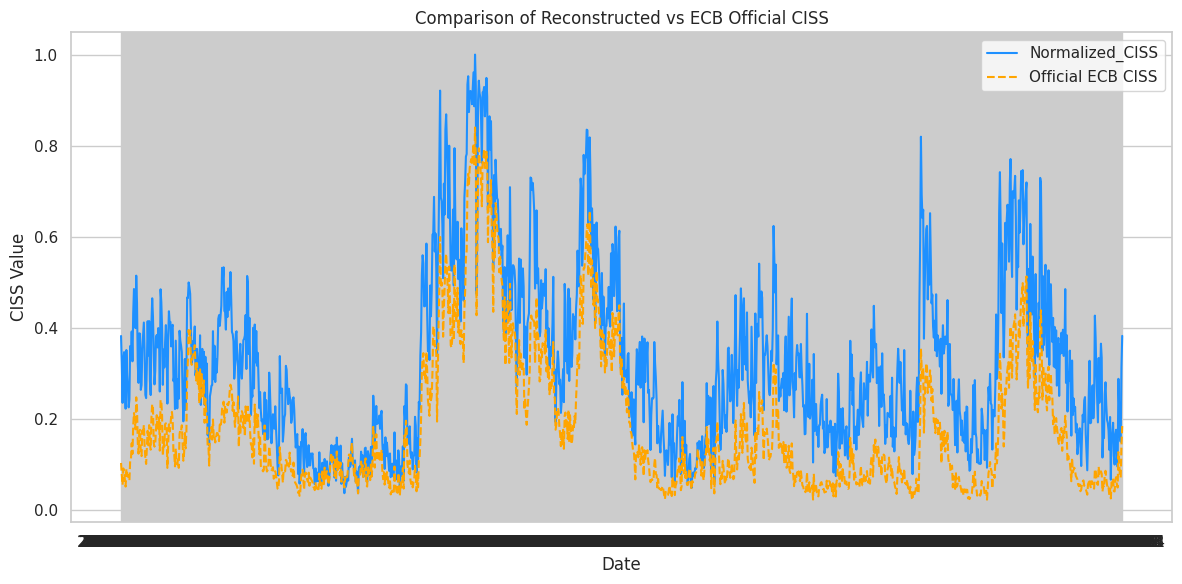

In [83]:
#Plotting Offical ECB CISS againt CISS calculated by reverse engineering in the previous code block

# Load ECB official CISS
ecb = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/ecb_ciss.xlsx", engine="openpyxl", header=1)

# Make sure 'Date' and 'CISS' columns exist and are clean
print("ECB Columns:", ecb.columns.tolist())  # Debug line

# Convert date column
ecb["Date"] = pd.to_datetime(ecb["Date"])

# Reset index of reconstructed CISS
df_ciss_reset = df_ciss.reset_index()

# Merge on 'Date'
combined = df_ciss_reset.merge(ecb[["Date", "ECB_CISS"]], on="Date", how="inner")

# Optional: Check how many rows were matched
print(f"Merged CISS shape: {combined.shape}")
# Normalize to [0, 1] based on max
combined['Normalized_CISS'] = combined['Reconstructed_CISS'] / combined['Reconstructed_CISS'].max()
combined.to_csv("combined.csv")
combined = pd.read_csv("combined.csv")
print(combined.head())

plt.figure(figsize=(12, 6))
plt.plot(combined["Date"], combined["Normalized_CISS"], label="Normalized_CISS", color="dodgerblue")
plt.plot(combined["Date"], combined["ECB_CISS"], label="Official ECB CISS", linestyle="--", color="orange")

plt.title("Comparison of Reconstructed vs ECB Official CISS")
plt.xlabel("Date")
plt.ylabel("CISS Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("CISS_Comparison.png")
plt.show()

In [84]:
#Creating a single data file now and calling it 'data'

merged['Date'] = pd.to_datetime(merged['Date'])
inverted_subindices['Date'] = pd.to_datetime(inverted_subindices['Date'])
reconstructed_ciss['Date'] = pd.to_datetime(reconstructed_ciss['Date'])
combined['Date'] = pd.to_datetime(combined['Date'])
data = merged.merge(inverted_subindices, on='Date') \
               .merge(reconstructed_ciss, on='Date') \
               .merge(combined, on='Date')
data = data.dropna().copy()
print(data.head())

   Year       Date  ForwardRateUSDtoEUR  ForwardRateUSDtoEUR_low  \
0  2000 2000-01-07             0.971912                 0.967586   
1  2000 2000-01-14             0.987654                 0.973141   
2  2000 2000-01-21             0.991179                 0.980777   
3  2000 2000-01-28             1.026167                 1.010611   
4  2000 2000-02-04             1.017812                 1.005935   

   ForwardRateUSDtoEUR_high  SpotRateUSDtoEUR  USDTreasuryRate  EUROBIR  Year  \
0                  0.975134          0.971440             5.22    3.322  2000   
1                  0.988826          0.987362             5.25    3.320  2000   
2                  0.995124          0.990099             5.31    3.310  2000   
3                  1.027221          1.024066             5.48    3.486  2000   
4                  1.025851          1.024590             5.50    3.492  2000   

   GDP_growth  ...  TradingCost  Bond_Input  Equity_Input  \
0      0.0408  ...     0.007770    0.150432

In [85]:
#Create lag features (1-period)
# -------------------------------
data["x_lag_1"] = data["x"].shift(1)
data.dropna(inplace=True)

# -------------------------------
# PCA on macroeconomic input features
# -------------------------------
macro_features = ["x_lag_1", "Bond_Input", "Equity_Input", "FX_Input", "Intermediaries_Input"]
X_macro = data[macro_features].values

# Standardize macro features
scaler_macro = StandardScaler()
X_macro_scaled = scaler_macro.fit_transform(X_macro)

# Optimal PCA: Choose # components to explain ~95% variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_macro_scaled)

print(f"PCA Components: {X_pca.shape[1]}")
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# -------------------------------
# Add trading cost as separate conditioning variable
# -------------------------------
trading_cost = data["TradingCost"].values.reshape(-1, 1)

# Concatenate PCA features + trading cost
X_final = np.hstack([X_pca, trading_cost])

# Standardize entire input space (optional but better for kernel scale)
scaler_final = StandardScaler()
X_final_scaled = scaler_final.fit_transform(X_final)

# Output variable
y = data["x"].values





PCA Components: 4
Explained Variance Ratio: [0.72604004 0.14117136 0.06380086 0.04202642]


In [86]:
#Kernel weighted Quantile Regression for estimating the 'neutral band', and calculating CIP stress measure

# -------------------------------

def gaussian_kernel(dist, h):
    return np.exp(-0.5 * (dist / h)**2)

def kernel_quantile_estimate(X_train, y_train, X_pred, tau, h, kernel_func):
    dists = cdist(X_pred, X_train)
    weights = kernel_func(dists, h)
    quantiles = []
    for i in range(weights.shape[0]):
        w = weights[i]
        if np.all(w == 0) or np.isnan(w).any():
            quantiles.append(np.nan)
            continue
        sorted_idx = np.argsort(y_train)
        y_sorted = y_train[sorted_idx]
        w_sorted = w[sorted_idx]
        w_cumsum = np.cumsum(w_sorted)
        if w_cumsum[-1] == 0:
            quantiles.append(np.nan)
            continue
        w_cumsum /= w_cumsum[-1]
        idx = np.searchsorted(w_cumsum, tau)
        q_value = y_sorted[min(idx, len(y_sorted) - 1)]
        quantiles.append(float(q_value))
    return np.array(quantiles)

# Estimate upper and lower bands
taus = [0.05, 0.95]
h_opt = 5  # Bandwidth

for tau in taus:
    print(f"Estimating τ = {tau}")
    data[f"Q{tau*100:.1f}"] = kernel_quantile_estimate(X_final_scaled, y, X_final_scaled, tau, h_opt, gaussian_kernel)

# -------------------------------
# 7. Estimate Neutral Band & Stress
# -------------------------------

data["Band_Width"] = data["Q95.0"] - data["Q5.0"]


# Compute CIP stress: deviation outside the neutral band
# Ensure equal lengths — use the smallest length among them
n = min(len(X_final_scaled), len(y), len(data))
X_final_scaled = X_final_scaled[:n]
y = y[:n]
data = data.iloc[:n].reset_index(drop=True)

# Convert y to NumPy for elementwise ops

y_vals = y

eps = 1e-6

data["CIP_Stress"] = np.where(
    (y_vals < (data["Q5.0"] - eps)) | (y_vals > (data["Q95.0"] + eps)),
    np.maximum(np.abs(y_vals - data["Q5.0"]), np.abs(y_vals - data["Q95.0"])),
    0
)
data["CIP_Stress_Log"] = np.log1p(data["CIP_Stress"])


#Save file with results
data.to_csv("data_withresults.csv", index=False)
data_withresults = pd.read_csv("data_withresults.csv")
print(data_withresults.head())

non_zero_pct = (data["CIP_Stress"] > 0).mean() * 100
print(f"CIP Stress is non-zero {non_zero_pct:.2f}% of the time.")



Estimating τ = 0.05
Estimating τ = 0.95
   Year        Date  ForwardRateUSDtoEUR  ForwardRateUSDtoEUR_low  \
0  2000  2000-01-14             0.987654                 0.973141   
1  2000  2000-01-21             0.991179                 0.980777   
2  2000  2000-01-28             1.026167                 1.010611   
3  2000  2000-02-04             1.017812                 1.005935   
4  2000  2000-02-11             1.013788                 1.012351   

   ForwardRateUSDtoEUR_high  SpotRateUSDtoEUR  USDTreasuryRate  EUROBIR  \
0                  0.988826          0.987362             5.25    3.320   
1                  0.995124          0.990099             5.31    3.310   
2                  1.027221          1.024066             5.48    3.486   
3                  1.025851          1.024590             5.50    3.492   
4                  1.021764          1.015538             5.49    3.490   

   Year.1  GDP_growth  ...  Unnamed: 0  Reconstructed_CISS_y  ECB_CISS  \
0    2000      0.040

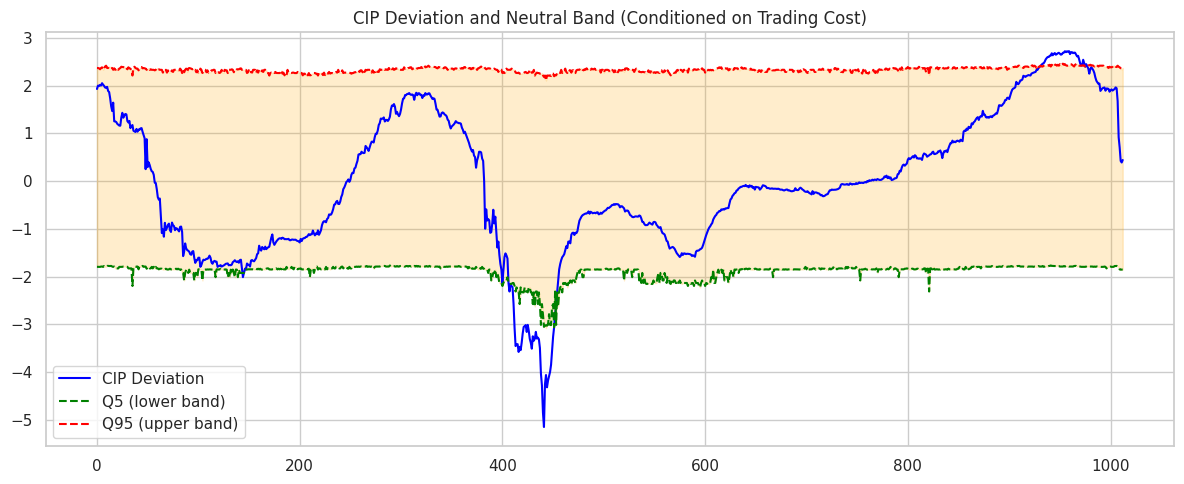

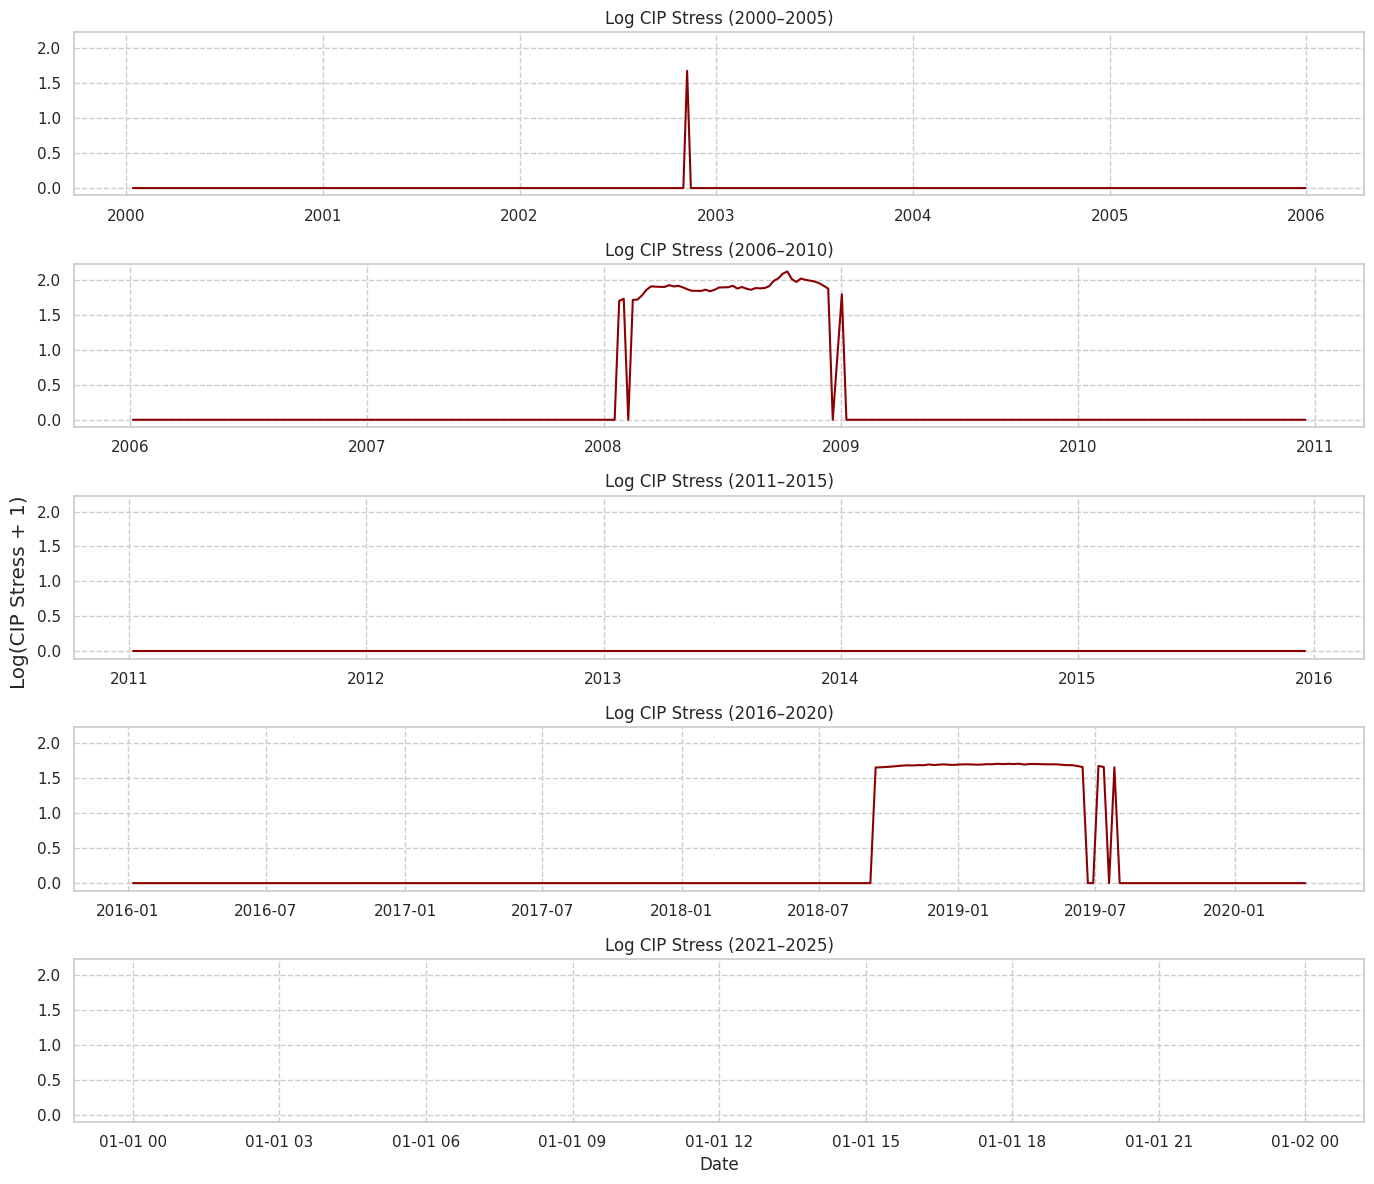

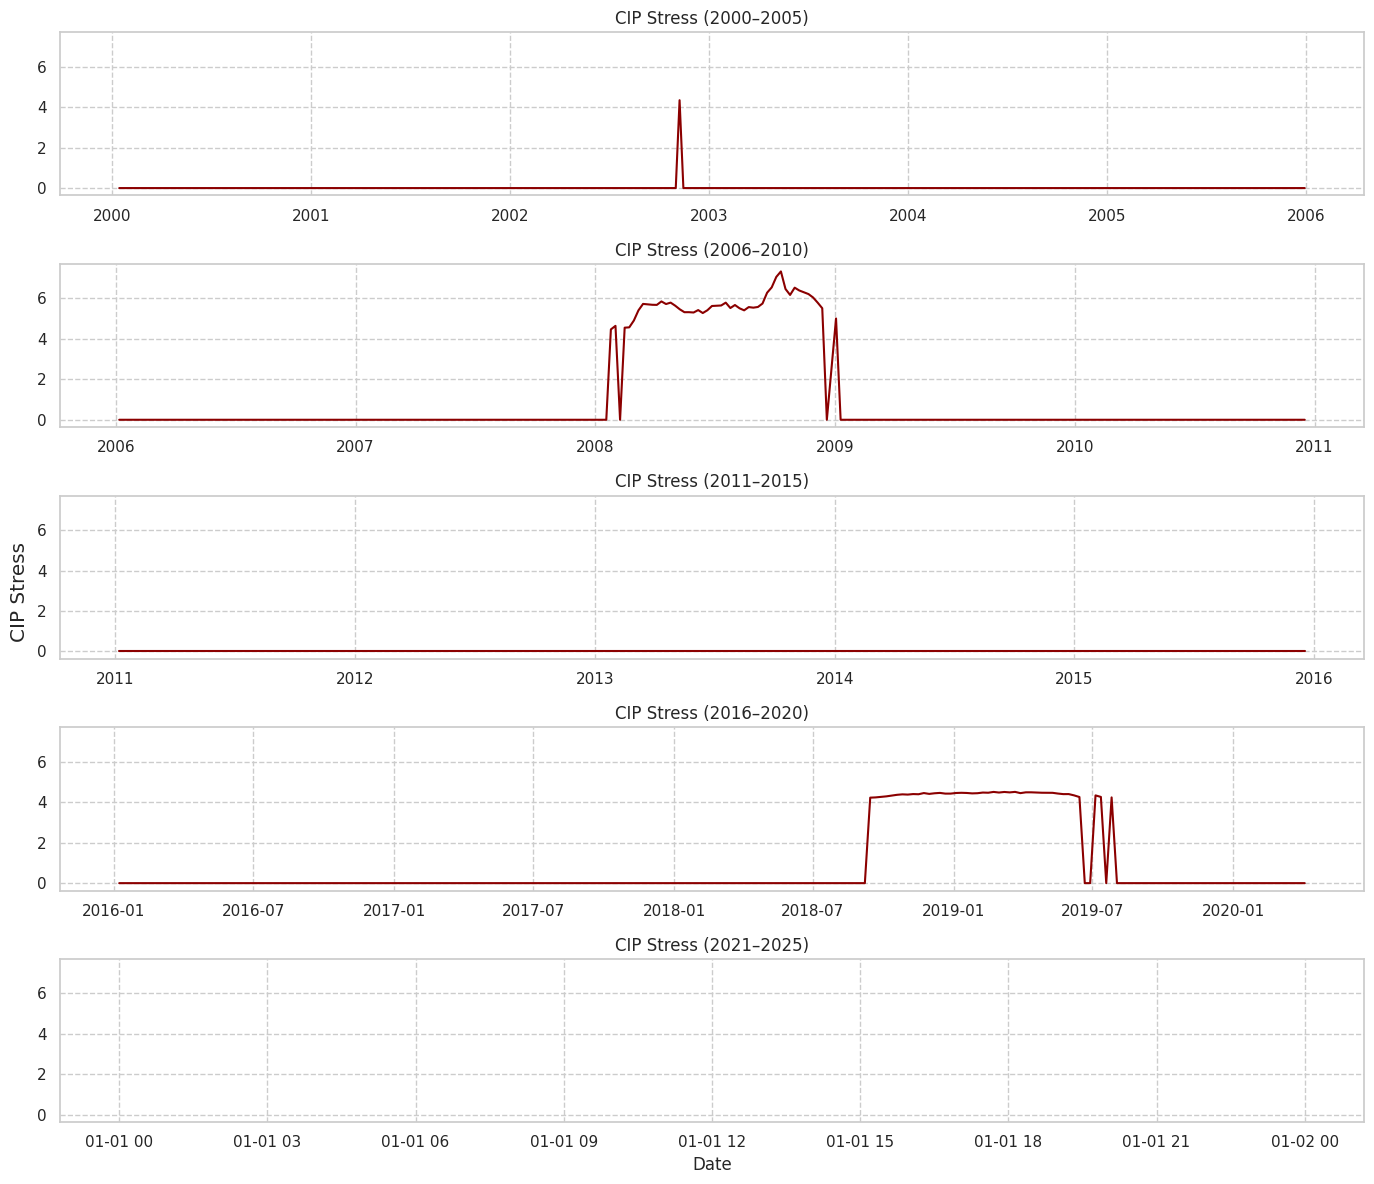

In [87]:
#Plots
#Plot the neutral band with original x

# -------------------------------

plt.figure(figsize=(12, 5))
plt.plot(data.index, y, label="CIP Deviation", color="blue")
plt.plot(data.index, data["Q5.0"], label="Q5 (lower band)", color="green", linestyle="--")
plt.plot(data.index, data["Q95.0"], label="Q95 (upper band)", color="red", linestyle="--")
plt.fill_between(data.index, data["Q5.0"], data["Q95.0"], color="orange", alpha=0.2)
plt.title("CIP Deviation and Neutral Band (Conditioned on Trading Cost)")
plt.legend()
plt.tight_layout()
plt.show()

#Faceted log stress plots
sns.set(style="whitegrid")
year_bins = [(2000, 2005), (2006, 2010), (2011, 2015), (2016, 2020), (2021, 2025)]
fig, axes = plt.subplots(len(year_bins), 1, figsize=(14, 12), sharey=True)

for i, (start, end) in enumerate(year_bins):
    ax = axes[i]
    data_withresults["Date"] = pd.to_datetime(data_withresults["Date"])
    mask = (data_withresults["Date"].dt.year >= start) & (data_withresults["Date"].dt.year <= end)
    ax.plot(data_withresults["Date"][mask], data_withresults["CIP_Stress_Log"][mask], color="darkred", linewidth=1.5)
    ax.set_title(f"Log CIP Stress ({start}–{end})", fontsize=12)
    ax.grid(True, linestyle="--")

axes[-1].set_xlabel("Date")
fig.supylabel("Log(CIP Stress + 1)")
plt.tight_layout()
plt.savefig("CIP_Stress_Log_Faceted.png", dpi=300, transparent=True)
plt.show()

#Faceted stress plots
sns.set(style="whitegrid")
year_bins = [(2000, 2005), (2006, 2010), (2011, 2015), (2016, 2020), (2021, 2025)]
fig, axes = plt.subplots(len(year_bins), 1, figsize=(14, 12), sharey=True)

for i, (start, end) in enumerate(year_bins):
    ax = axes[i]
    data_withresults["Date"] = pd.to_datetime(data_withresults["Date"])
    mask = (data_withresults["Date"].dt.year >= start) & (data_withresults["Date"].dt.year <= end)
    ax.plot(data_withresults["Date"][mask], data_withresults["CIP_Stress"][mask], color="darkred", linewidth=1.5)
    ax.set_title(f"CIP Stress ({start}–{end})", fontsize=12)
    ax.grid(True, linestyle="--")

axes[-1].set_xlabel("Date")
fig.supylabel("CIP Stress")
plt.tight_layout()
plt.savefig("CIP_Stress_Faceted.png", dpi=300, transparent=True)
plt.show()

In [88]:
#Checking Stationarity and transforming variables where necessary
def check_stationarity(series, name):
    result = adfuller(series.dropna())
    print(f"ADF Test for {name}:")
    print(f"  Test Statistic = {result[0]:.4f}")
    print(f"  p-value = {result[1]:.4f}")
    print("  Stationary" if result[1] < 0.05 else "  Non-stationary")
    print("")

check_stationarity(data_withresults["ECB_CISS"], "ECB_CISS")
check_stationarity(data_withresults["Band_Width"], "Band_Width")
check_stationarity(data_withresults["GDP_growth"], "GDP_growth")
check_stationarity(data_withresults["Bond_Input"], "Bond_Input")
check_stationarity(data_withresults["Equity_Input"], "Equity_Input")
check_stationarity(data_withresults["FX_Input"], "FX_Input")
check_stationarity(data_withresults["Intermediaries_Input"], "Intermediaries_Input")

# Save current data
data_withresults.to_csv("data_withresults.csv", index=False)

# Reload cleanly
data_withresults = pd.read_csv("data_withresults.csv")

# Apply differencing AFTER loading
data_withresults["ECB_CISS_diff"] = data_withresults["ECB_CISS"].diff()
data_withresults["GDP_growth_diff"] = data_withresults["GDP_growth"].diff()
data_withresults["Intermediaries_Input_diff"] = data_withresults["Intermediaries_Input"].diff()

# Drop NA rows if needed
data_withresults.dropna(subset=["ECB_CISS_diff", "GDP_growth_diff", "Intermediaries_Input_diff"], inplace=True)

# Save current data
data_withresults.to_csv("data_withresults.csv", index=False)

# Now check stationarity
check_stationarity(data_withresults["ECB_CISS_diff"], "ECB_CISS_diff")
check_stationarity(data_withresults["GDP_growth_diff"], "GDP_growth_diff")
check_stationarity(data_withresults["Intermediaries_Input_diff"], "Intermediaries_Input_diff")

ADF Test for ECB_CISS:
  Test Statistic = -2.8453
  p-value = 0.0521
  Non-stationary

ADF Test for Band_Width:
  Test Statistic = -2.8238
  p-value = 0.0549
  Non-stationary

ADF Test for GDP_growth:
  Test Statistic = -2.4618
  p-value = 0.1250
  Non-stationary

ADF Test for Bond_Input:
  Test Statistic = -2.8644
  p-value = 0.0496
  Stationary

ADF Test for Equity_Input:
  Test Statistic = -3.0375
  p-value = 0.0315
  Stationary

ADF Test for FX_Input:
  Test Statistic = -3.8731
  p-value = 0.0022
  Stationary

ADF Test for Intermediaries_Input:
  Test Statistic = -2.2515
  p-value = 0.1881
  Non-stationary

ADF Test for ECB_CISS_diff:
  Test Statistic = -28.4053
  p-value = 0.0000
  Stationary

ADF Test for GDP_growth_diff:
  Test Statistic = -31.7805
  p-value = 0.0000
  Stationary

ADF Test for Intermediaries_Input_diff:
  Test Statistic = -15.4520
  p-value = 0.0000
  Stationary



In [89]:
#Checking for multicollinaerity
features = ["Band_Width", "Bond_Input", "Equity_Input", "FX_Input", "Intermediaries_Input_diff"]
X = add_constant(data_withresults[features].dropna())
vifs = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("VIF Results:")
for i, var in enumerate(X.columns):
    print(f"{var}: {vifs[i]:.2f}")

VIF Results:
const: 1104.21
Band_Width: 2.00
Bond_Input: 4.03
Equity_Input: 2.85
FX_Input: 2.50
Intermediaries_Input_diff: 1.06


In [90]:
# Level OLS Regression
import statsmodels.api as sm
df_reg = pd.read_csv("data_withresults.csv", parse_dates=["Date"])
X_vars = ["Band_Width", "Bond_Input", "Equity_Input", "FX_Input", "Intermediaries_Input_diff"]
X = df_reg[X_vars]
X = sm.add_constant(X)  # Adds intercept
y = df_reg["ECB_CISS_diff"]

model = sm.OLS(y, X, missing='drop').fit()
print(model.summary())

df_reg = pd.read_csv("data_withresults.csv", parse_dates=["Date"])
X_vars = ["Band_Width"]
X = df_reg[X_vars]
X = sm.add_constant(X)  # Adds intercept
y = df_reg["ECB_CISS_diff"]

model = sm.OLS(y, X, missing='drop').fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          ECB_CISS_diff   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     248.1
Date:                Sun, 18 May 2025   Prob (F-statistic):          1.16e-172
Time:                        10:20:51   Log-Likelihood:                 2168.3
No. Observations:                1012   AIC:                            -4325.
Df Residuals:                    1006   BIC:                            -4295.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [91]:
# VAR Model to regress GDP Growth on CISS

# Function to check stationarity and difference if necessary
def adf_test(series):
    result = adfuller(series.dropna())
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] <= 0.05:
        print("The series is stationary.")
        return False  # Already stationary
    else:
        print("The series is non-stationary. Differencing is required.")
        return True  # Needs differencing

def difference_series(series):
    """Differencing the series to make it stationary."""
    return series.diff().dropna()

# Step 1: Check for stationarity and difference if necessary for ARIMA & VAR
def make_stationary(data_withresults, columns):
    for col in columns:
        if adf_test(data_withresults[col]):
            data_withresults[col] = difference_series(data_withresults[col])
    return data_withresults

# Check stationarity and difference the necessary columns
data_withresults = make_stationary(data_withresults, ["GDP_growth_diff", "ECB_CISS_diff", "Band_Width"])


max_lags = 10
significant_lags = []

df_diff = data_withresults[["GDP_growth_diff", "ECB_CISS_diff"]].dropna()

for lag in range(1, max_lags + 1):
    model = VAR(df_diff)
    results = model.fit(lag)
    print(f"\n--- VAR({lag}) ---")
    print(results.summary())

    # Check if any cross-lagged coefficients are significant
    gdp_eq = results.params.filter(like='GDP_growth_diff')
    ciss_eq = results.params.filter(like='ECB_CISS_diff')

    # You could refine this to check p-values, not just coefficients
    if any(results.pvalues['GDP_growth_diff'].filter(like='CISS__') < 0.05):
        significant_lags.append(lag)

print("\nSignificant CISS lags affecting GDP_growth_diff found at lags:", significant_lags)

granger1 = results.test_causality('GDP_growth_diff', ['ECB_CISS_diff'], kind='f')
granger2 = results.test_causality('ECB_CISS_diff', ['GDP_growth_diff'], kind='f')
print("Does CISS cause GDP?")
print(granger1.summary())

print("\nDoes GDP cause CISS?")
print(granger2.summary())


ADF Statistic: -31.780542764956586
p-value: 0.0
The series is stationary.
ADF Statistic: -28.40525883968724
p-value: 0.0
The series is stationary.
ADF Statistic: -2.8253040215991696
p-value: 0.0547491870469757
The series is non-stationary. Differencing is required.

--- VAR(1) ---
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 18, May, 2025
Time:                     10:20:52
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -18.1130
Nobs:                     1011.00    HQIC:                  -18.1311
Log likelihood:           6307.78    FPE:                1.32114e-08
AIC:                     -18.1422    Det(Omega_mle):     1.31333e-08
--------------------------------------------------------------------
Results for equation GDP_growth_diff
                        coefficient       std. error           t-stat            prob
------

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot


--- VAR(9) ---
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 18, May, 2025
Time:                     10:20:52
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -17.9232
Nobs:                     1003.00    HQIC:                  -18.0386
Log likelihood:           6273.42    FPE:                1.36532e-08
AIC:                     -18.1093    Det(Omega_mle):     1.31503e-08
--------------------------------------------------------------------
Results for equation GDP_growth_diff
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                     -0.000064         0.000089           -0.715           0.474
L1.GDP_growth_diff         0.003586         0.031893            0.112           0.910
L1.ECB_CISS_di

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [92]:
# VAR Model to regress GDP Growth on CISS and Bandwidth



max_lags = 10
significant_lags = []

# Assuming 'data_withresults' contains the necessary variables, and Band_Width_lag1 exists
df_diff = data_withresults[["GDP_growth_diff", "ECB_CISS_diff", "Band_Width"]].dropna()

# Loop through different lags and fit the VAR model
for lag in range(1, max_lags + 1):
    model = VAR(df_diff)
    results = model.fit(lag)
    print(f"\n--- VAR({lag}) ---")
    print(results.summary())

    # Check if any cross-lagged coefficients are significant
    # You can check the coefficients corresponding to the GDP and CISS
    gdp_eq = results.params.filter(like='GDP_growth_diff')
    ciss_eq = results.params.filter(like='ECB_CISS_diff')
    bandwidth_eq = results.params.filter(like='Band_Width')

    # Check if any CISS or Band_Width lags are significant for GDP
    if any(results.pvalues['GDP_growth_diff'].filter(like='CISS__') < 0.05) or \
       any(results.pvalues['GDP_growth_diff'].filter(like='Band_Width') < 0.05):
        significant_lags.append(lag)

print("\nSignificant lags affecting GDP_growth_diff found at lags:", significant_lags)


--- VAR(1) ---
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 18, May, 2025
Time:                     10:20:52
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -23.6566
Nobs:                     1010.00    HQIC:                  -23.6928
Log likelihood:           7688.69    FPE:                5.02001e-11
AIC:                     -23.7150    Det(Omega_mle):     4.96084e-11
--------------------------------------------------------------------
Results for equation GDP_growth_diff
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                     -0.000063         0.000088           -0.713           0.476
L1.GDP_growth_diff         0.005669         0.031557            0.180           0.857
L1.ECB_CISS_di

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 18, May, 2025
Time:                     10:20:52
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -23.6087
Nobs:                     1007.00    HQIC:                  -23.7267
Log likelihood:           7735.20    FPE:                4.61547e-11
AIC:                     -23.7990    Det(Omega_mle):     4.44123e-11
--------------------------------------------------------------------
Results for equation GDP_growth_diff
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                     -0.000063         0.000088           -0.716           0.474
L1.GDP_growth_diff         0.003682         0.031783            0.116           0.908
L1.ECB_CISS_diff           0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)



--- VAR(6) ---
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 18, May, 2025
Time:                     10:20:52
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -23.5029
Nobs:                     1005.00    HQIC:                  -23.6757
Log likelihood:           7729.14    FPE:                4.69681e-11
AIC:                     -23.7816    Det(Omega_mle):     4.44019e-11
--------------------------------------------------------------------
Results for equation GDP_growth_diff
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                     -0.000063         0.000089           -0.714           0.475
L1.GDP_growth_diff         0.004060         0.031870            0.127           0.899
L1.ECB_CISS_di

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 18, May, 2025
Time:                     10:20:52
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -23.3425
Nobs:                     1002.00    HQIC:                  -23.5977
Log likelihood:           7719.48    FPE:                4.82769e-11
AIC:                     -23.7541    Det(Omega_mle):     4.44458e-11
--------------------------------------------------------------------
Results for equation GDP_growth_diff
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                     -0.000063         0.000089           -0.713           0.476
L1.GDP_growth_diff         0.004989         0.032123            0.155           0.877
L1.ECB_CISS_diff           0.0

   Year  ForwardRateUSDtoEUR  ForwardRateUSDtoEUR_low  \
4  2000             1.013788                 1.012351   
5  2000             1.013993                 1.009693   
6  2000             1.026483                 1.006644   
7  2000             1.041992                 1.033058   
8  2000             1.038637                 1.031992   

   ForwardRateUSDtoEUR_high  SpotRateUSDtoEUR  USDTreasuryRate  EUROBIR  \
4                  1.021764          1.015538             5.49    3.490   
5                  1.019784          1.015228             5.58    3.531   
6                  1.028489          1.024275             5.62    3.598   
7                  1.042753          1.039717             5.63    3.633   
8                  1.041884          1.035304             5.70    3.736   

   Year.1  GDP_growth       rho  ...  Band_Width_lag1  Band_Width_lag2  \
4    2000      0.0408 -0.001725  ...        -0.018761        -0.006797   
5    2000      0.0408 -0.001218  ...         0.019290     

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


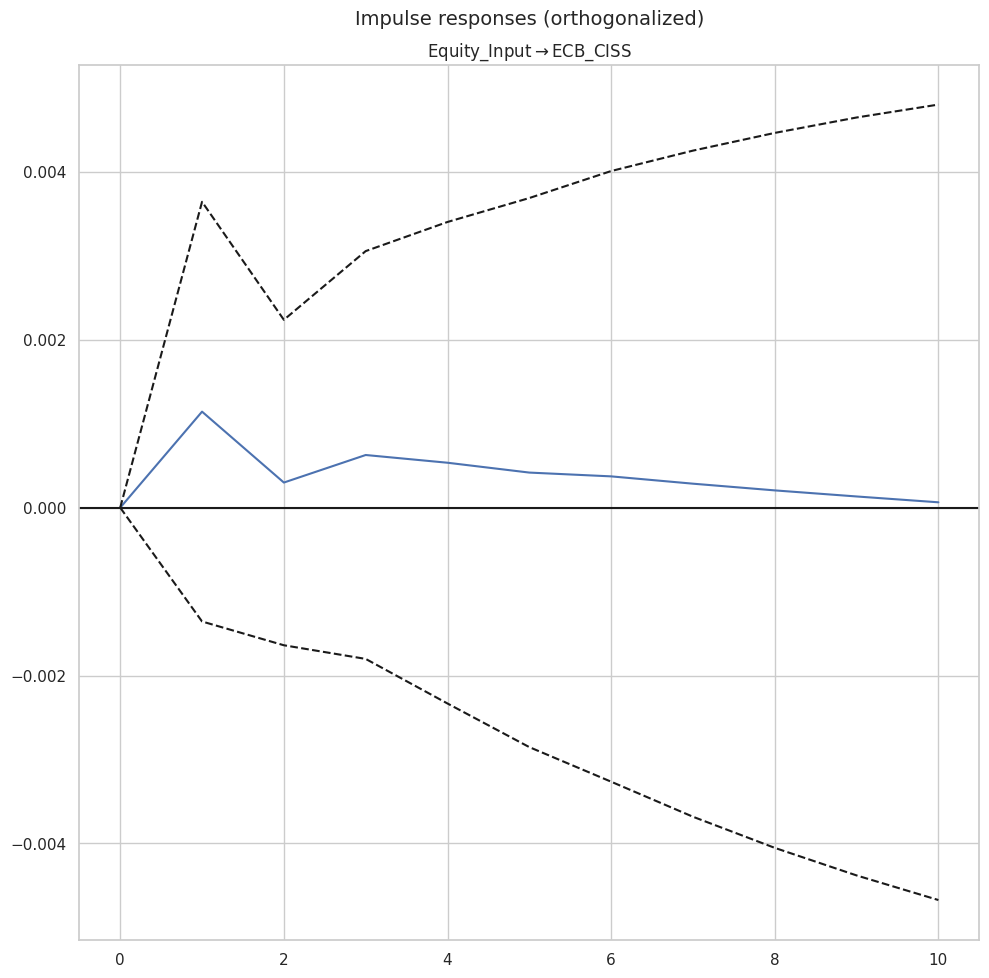

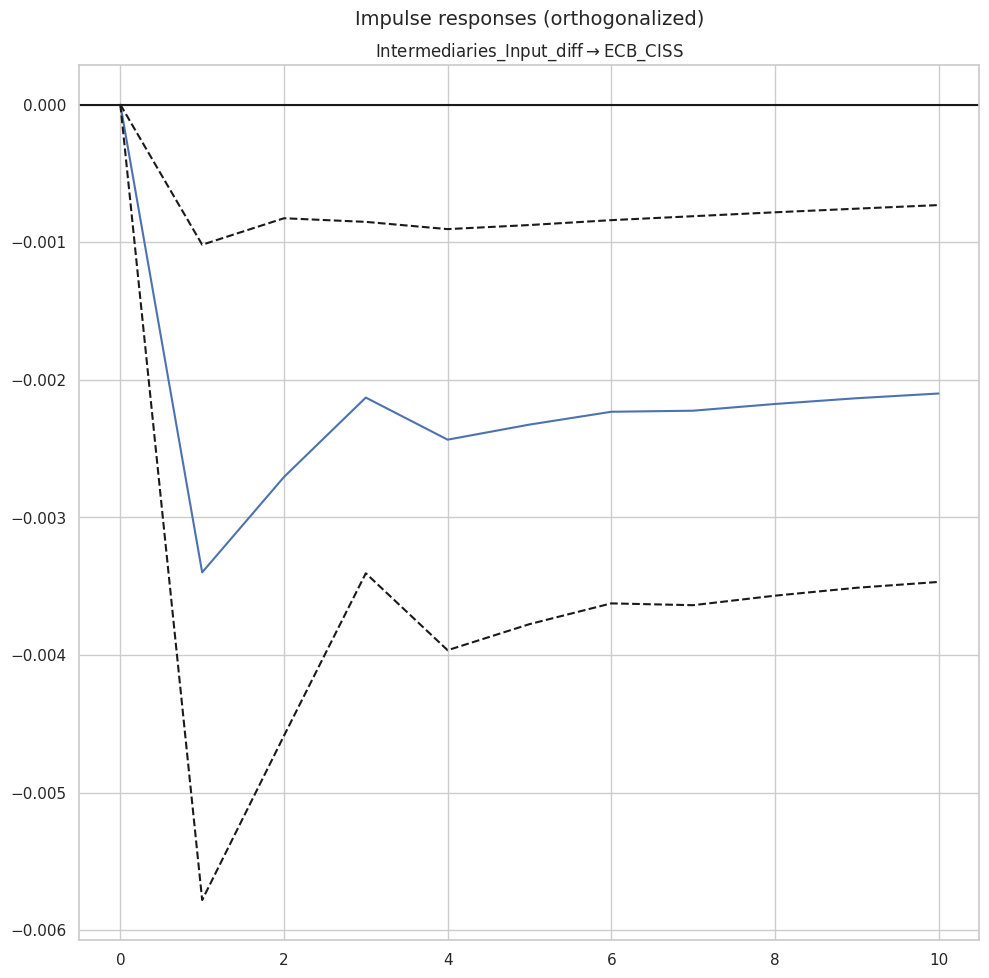

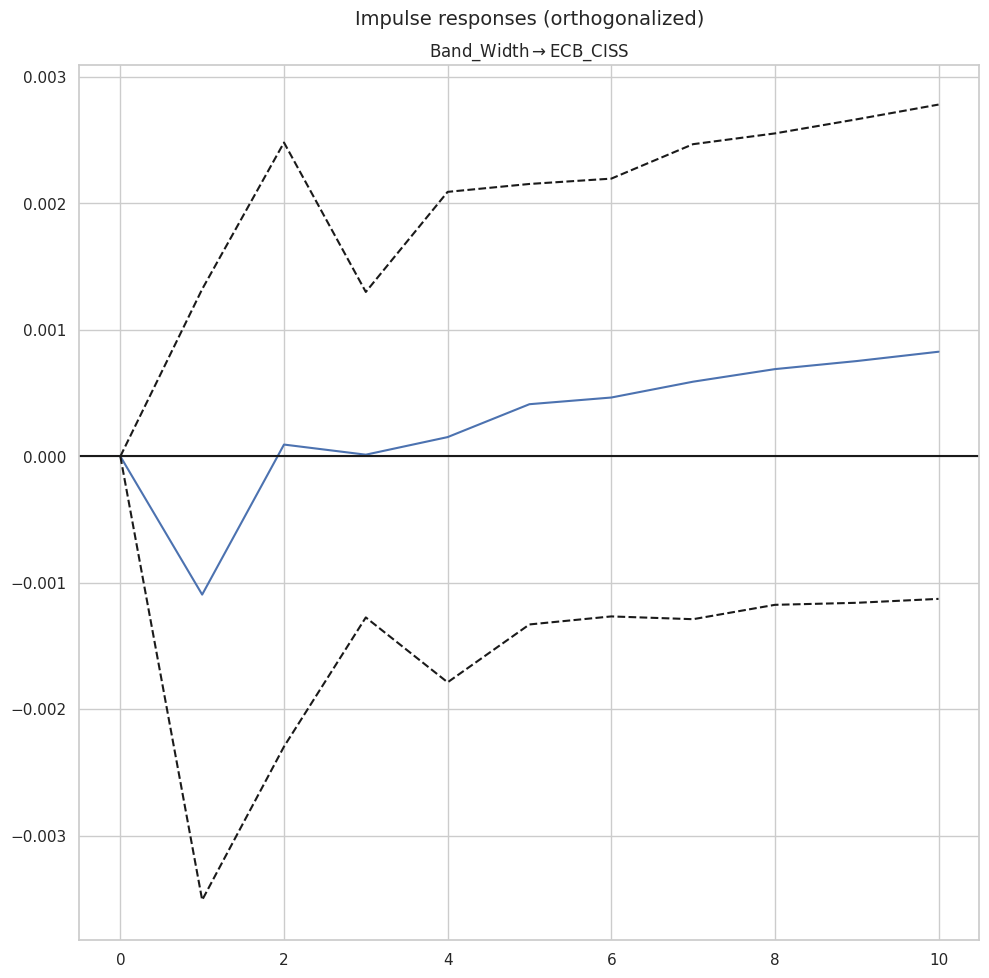

In [93]:
# Checking VAR results for CISS inputs, bandwidth to CISS

df_lagged = data_withresults.copy()

# Reduce the number of lags to avoid potential multicollinearity
for col in ['Band_Width', 'Bond_Input', 'Equity_Input', 'FX_Input', 'Intermediaries_Input_diff']:
    for lag in range(1, 3):  # Reduced lags to 1 and 2
        df_lagged[f'{col}_lag{lag}'] = data_withresults[col].shift(lag)

# Drop rows with missing values due to lagging
df_lagged = df_lagged.dropna()
numerical_df = df_lagged.select_dtypes(include=['float64', 'int64'])
print(numerical_df.head())

numerical_df_no_date = numerical_df.drop(columns=['Year'])

# Fit the VAR model, excluding 'Date' column and using fewer lags
# Only include 'Band_Width_lag1' as it's likely the most relevant lag
model = VAR(numerical_df_no_date[
    ['ECB_CISS', 'Band_Width', 'Bond_Input', 'Equity_Input',
     'FX_Input', 'Intermediaries_Input_diff']
])

results = model.fit(2)  # Fit with a max lag of 2

# Generate IRFs up to 10 periods ahead
irf = results.irf(10)

# Plot IRFs: Response of ECB_CISS to key impulses
irf.plot(impulse='Equity_Input', response='ECB_CISS', orth=True)
irf.plot(impulse='Intermediaries_Input_diff', response='ECB_CISS', orth=True)
irf.plot(impulse='Band_Width', response='ECB_CISS', orth=True)

# Summary of results
print(results.summary())

#vif for multicollinearity
selected_vars = ['ECB_CISS', 'Band_Width', 'Bond_Input', 'Equity_Input', 'FX_Input', 'Intermediaries_Input_diff']
X = numerical_df_no_date[selected_vars]

# Add a constant term for VIF calculation
X = add_constant(X)

# Compute VIF
vif_df = pd.DataFrame()
vif_df["Variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_df)